In [1]:
import pandas as pd
import numpy as np
from numpy.fft import fft, ifft
from scipy.signal import convolve, correlate
from scipy.spatial import distance
%matplotlib inline

def dist_est_BF(x,y):
    # Brute Force function
    m = len(y)
    n = len(x)
    dist=np.zeros(n-m)
    for i in range(0,n-m):
        dist[i] = distance.euclidean(x[i:i+m],y)
    return dist

def dist_est_fast1(x,y):
    #x is the data, y is the query
    m = len(y)
    n = len(x)

    # O(n) shit here!
    meany = np.mean(y);
    sigmay = np.std(y,ddof=0);

    meanx = pd.Series(x).rolling(window=m,min_periods=0).mean().values
    sigmax = pd.Series(x).rolling(window=m,min_periods=0).std(ddof=0).fillna(0).values
    
    y = y[::-1];#Reverse the query
    y = np.pad(y, (0, int(n - len(y)%n)), 'constant')

    #FFT: O(n log n) magic!
    X = fft(x);
    Y =  fft(y);
    Z = X*Y;
    z =  ifft(Z)
    
    dist = 2*(m-(z[m-1:n]-m*meanx[m-1:n]*meany)/(sigmax[m-1:n]*sigmay));
    return np.sqrt(dist)

def dist_est_fast2(x,y):
    #x is the data, y is the query
    m = len(y)
    n = len(x)

    # O(n) shit here!
    meany = np.mean(y);
    sigmay = np.std(y,ddof=0);
    # Running stats
    meanx = movmean_fast(x,m+1)
    sigmax = pd.Series(x).rolling(window=m,min_periods=0).std(ddof=0).fillna(0).values
    
    y = y[::-1];#Reverse the query
    y = np.pad(y, (0, int(n - len(y)%n)), 'constant')

    #FFT: O(n log n) magic!
    X = fft(x);
    Y = fft(y);
    Z = X*Y;
    z =  ifft(Z)
    
    dist = 2*(m-(z[m-1:n]-m*meanx[m-1:n]*meany)/(sigmax[m-1:n]*sigmay));
    return np.sqrt(dist)
from scipy.ndimage.filters import uniform_filter1d
def movmean_bf(x,m):
    n=len(x)
    movmean=np.zeros(n)
    for i in range(n):
        last_m_indices=range(i,-1,-1)[0:m+1]
        movmean[i]=np.mean(x[last_m_indices])
    return movmean
def movmean_pd(A,m):
    return pd.Series(A).rolling(window=m+1,min_periods=0).mean().values

def movmean_fast(A,m):
    orig=np.int(m/2)   
    movmean=uniform_filter1d(A.astype(float), m+1, mode='constant', origin=orig)
    movmean[0:m]=np.cumsum(A[0:m])/(np.arange(1,m+1)+0.0)
    return movmean

# This pickle file has a dict with 3 elements: 
- y: Search Sequence
- x: Source Sequence
- d - distance vector

These were generated in MATLAB and exported.

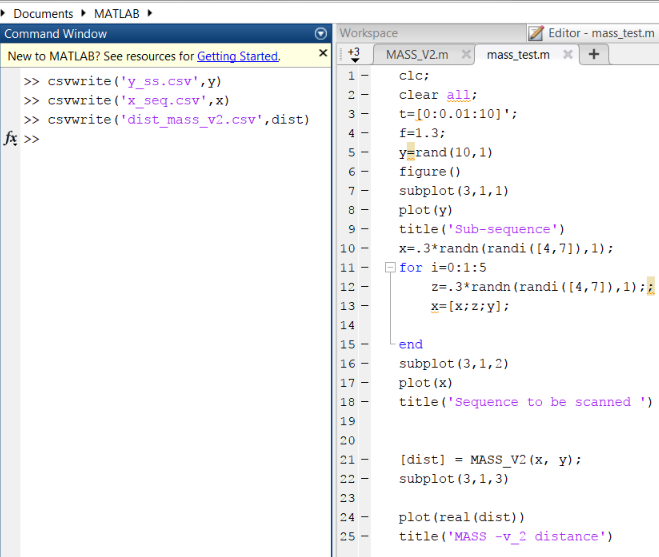

In [2]:
import pickle
dict_test = pickle.load( open( "dict_ground_truth.pkl", "rb" ) )
dict_test.keys()
from IPython.display import Image
Image(filename='matlab_mass.png') 

# Let's benchmark!

C:\toolkits.win\anaconda3-4.4.0\lib\site-packages\numpy\core\numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


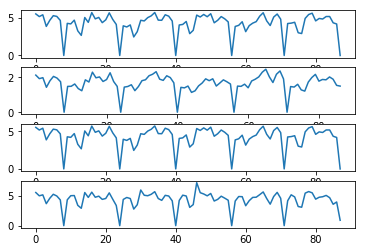

In [3]:
d_true=(dict_test['d'].values.flatten())
x_true=dict_test['x'].values.flatten()
y_true=dict_test['y'].values.flatten()
##################################
d_bf=dist_est_BF(x_true,y_true)
d_fast_1=dist_est_fast1(x_true,y_true)
d_bf=dist_est_BF(x_true,y_true)
d_fast_2=dist_est_fast2(x_true,y_true)

d_true[-1]=0
d_true_float=np.zeros(len(d_true))
for i in range(len(d_true)):
    try:
        float(d_true[i])
        d_true_float[i]=float(d_true[i])
        
    except:
        d_true_float[i]=0
plt.figure()
plt.subplot(4,1,1)
plt.plot(d_true_float)
plt.subplot(4,1,2)
plt.plot(d_bf)
plt.subplot(4,1,3)
plt.plot(d_fast_1)
plt.subplot(4,1,4)
plt.plot(d_fast_2)